Import libraries

In [38]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

# Part 1 - Data Preprocessing

PATHS

In [39]:
primary_set = r"C:\Users\henry\Desktop\Project\Medical-X-Ray-Image-Classifier-Pneumonia-Detection\chest_xray"

train_set = os.path.join(primary_set, "train")
val_set = os.path.join(primary_set, "val")
test_set  = os.path.join(primary_set, "test")

Count the number of images in each category

In [40]:
def image_count(path):
    normal_image_count = len(os.listdir(os.path.join(path, "NORMAL")))
    pneumonia_image_count = len(os.listdir(os.path.join(path, "PNEUMONIA")))
    print(f"Normal: {normal_image_count}, Pneumonia: {pneumonia_image_count}")

# checking datasets
print("Training set:")
image_count(train_set)
print("\nValidation set:")
image_count(val_set)
print("\nTest set:")
image_count(test_set)

Training set:
Normal: 1341, Pneumonia: 3875

Validation set:
Normal: 8, Pneumonia: 8

Test set:
Normal: 234, Pneumonia: 389


## Data Augmentation

Set up image generators for loading and augmenting the images

In [41]:
train_image_gen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values to [0, 1]
    rotation_range=40,     # Random rotations
    width_shift_range=0.2, # Horizontal shift
    height_shift_range=0.2, # Vertical shift
    shear_range=0.2,       # Shear transformations
    zoom_range=0.2,        # Zoom in/out
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'    # Fill missing pixels
)

val_image_gen = ImageDataGenerator(rescale=1./255) # Only rescaling for validation and test sets

* I utilized the flow_from_directory method to import images from designated directories (train, validation, and test). This method automatically assigns labels to images based on their respective folder names, such as "NORMAL" and "PNEUMONIA."

* For the training dataset, images are resized to 150x150 pixels and processed in batches of 32. Additionally, I enabled shuffling to introduce randomness in data feeding, which helps mitigate overfitting.

* In the validation and test datasets, images are resized and batched in a similar manner; however, shuffling is disabled to maintain a consistent order for evaluation purposes.

* Given that this is a binary classification problem (Normal vs. Pneumonia), I set class_mode='binary', ensuring that each image is assigned a label of either 'Normal' (0) or 'Pneumonia' (1)

In [42]:
train_data = train_image_gen.flow_from_directory(
    train_set,
    target_size=(150, 150),  # Resize images to fit the model input
    batch_size=32,
    class_mode='binary',     # For binary classification (Normal vs Pneumonia)
    shuffle=True
)

val_data = val_image_gen.flow_from_directory(
    val_set,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_data = val_image_gen.flow_from_directory(
    test_set,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 623 images belonging to 2 classes.


## Inspecting Data

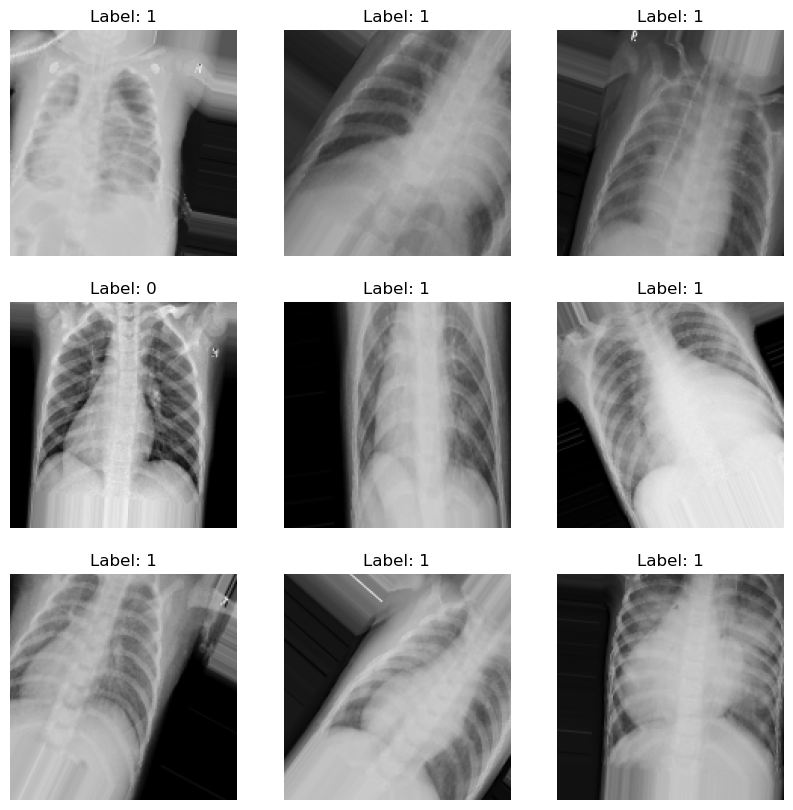

In [43]:
# Get a batch of images and labels
images, labels = next(train_data)

# Plot the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")  # Label will be 0 or 1
    plt.axis("off")
plt.show()

## Addressing Data Imbalance

* I began by extracting all images and their corresponding labels from the training and validation generators, converting them into NumPy arrays for more efficient data handling.

* After verifying the dataset structures, I confirmed that both the training and validation sets were correctly formatted with the appropriate number of samples.

* To enhance the validation set size and achieve a more balanced distribution, I randomly transferred 257 images from the training set to the validation set.

This adjustment provides a larger validation set, leading to a more reliable assessment of the model’s performance.

In [44]:
# Step 1: Extract images and labels from the train_data
X_train = []
y_train = []

for i in range(len(train_data)):
    images, labels = train_data[i]
    X_train.append(images)
    y_train.append(labels)

# Convert lists to NumPy arrays
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Inspecting the shape of the training data
print("X_train shape:", X_train.shape)  # is (num_samples, height, width, channels)
print("y_train shape:", y_train.shape)  # is (num_samples,)

X_train shape: (5216, 150, 150, 3)
y_train shape: (5216,)


In [45]:
# Step 1: Extract images and labels from the val_data
X_val = []
y_val = []

for i in range(len(val_data)):
    images, labels = val_data[i]
    X_val.append(images)
    y_val.append(labels)

# Convert lists to NumPy arrays
X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)

# Check the shape of the validation data
print("X_val shape:", X_val.shape)  # is (num_samples, height, width, channels)
print("y_val shape:", y_val.shape)  # is (num_samples,)

X_val shape: (16, 150, 150, 3)
y_val shape: (16,)


In [46]:
# Step 3: Move some images from the training set to the validation set
# Setting random seed for reproducibility
np.random.seed(42)

# Number of images to move
images_to_be_moved = 257

# Randomly select indices of images to move
indices_to_be_moved = np.random.choice(len(X_train), images_to_be_moved, replace=False)

# Move the selected images and labels from training to validation
X_val = np.concatenate([X_val, X_train[indices_to_be_moved]])
y_val = np.concatenate([y_val, y_train[indices_to_be_moved]])

# Remove the moved images from the training set
X_train = np.delete(X_train, indices_to_be_moved, axis=0)
y_train = np.delete(y_train, indices_to_be_moved, axis=0)

# Check the new sizes
print("New X_train shape:", X_train.shape)
print("New y_train shape:", y_train.shape)
print("New X_val shape:", X_val.shape)
print("New y_val shape:", y_val.shape)

New X_train shape: (4959, 150, 150, 3)
New y_train shape: (4959,)
New X_val shape: (273, 150, 150, 3)
New y_val shape: (273,)


## Flatten the images

In [47]:
num_samples, height, width, channels = X_train.shape
X_train_flat = X_train.reshape(num_samples, -1)  # Shape: (num_samples, height * width * channels)

## Set Training Imbalance Using SMOTE
* To address the class imbalance in the training dataset, I applied SMOTE (Synthetic Minority Over-sampling Technique), a method designed to generate synthetic samples for the underrepresented class instead of merely duplicating existing ones.

* SMOTE operates by selecting a sample from the minority class and generating new instances through interpolation between that sample and its nearest neighbors, effectively increasing the number of minority class samples.

* By incorporating these synthetic samples, SMOTE helps balance the dataset, reducing the model’s tendency to favor the majority class. This often results in improved classification performance, particularly when dealing with imbalanced data.

* Since SMOTE requires flattened data, I first transformed the images into a 2D format before applying the technique. After generating the synthetic samples, I reshaped the data back into its original 4D format (num_samples, height, width, channels) to ensure compatibility with the model.

In [48]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_flat_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)

# Reshape the flattened images back to their original shape
X_train_resampled = X_train_flat_resampled.reshape(-1, height, width, channels)

# Inspect the new class distribution
print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_train_resampled))

Original class distribution: Counter({1.0: 3676, 0.0: 1283})
Resampled class distribution: Counter({1.0: 3676, 0.0: 3676})


Original class distribution: Before applying SMOTE, we had a much larger number of pneumonia cases (3684) compared to normal cases (1275).

Resampled class distribution: After applying SMOTE, the minority class (normal) was upsampled to match the number of pneumonia cases, resulting in an equal number of instances for both classes (3481 each).

In [49]:
os.environ["OMP_NUM_THREADS"] = "16"  # Use 16 threads to speed things up
os.environ["TF_NUM_INTEROP_THREADS"] = "16"
os.environ["TF_NUM_INTRAOP_THREADS"] = "16"

* Load Pre-trained Model: The ResNet50 model, pre-trained on the ImageNet dataset, is loaded with its top (fully connected) layers removed. This allows it to function as a feature extractor while adapting to the specific input dimensions of the dataset.

* Add Custom Layers: Additional layers are incorporated on top of the ResNet50 base model:

    * A GlobalAveragePooling2D layer is used to reduce the feature map’s dimensionality.
    * A Dense layer with 1024 neurons and ReLU activation helps capture intricate patterns in the data.
    * A final Dense layer with a single neuron and sigmoid activation outputs a probability score for binary classification.
* Model Compilation: The model is compiled with the Adam optimizer, set to a learning rate of 0.0001. Binary cross-entropy is selected as the loss function for handling binary classification, while key performance metrics such as accuracy, precision, recall, and AUC are tracked.

* Training: The model is trained for 10 epochs using resampled data (enhanced with SMOTE to correct class imbalance), with a batch size of 32. Validation data is used throughout the training process to monitor the model’s performance.

In [50]:
# Load a pretrained model ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, channels))

# Add custom layers on top of the pretrained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Single neuron for binary classification

# Combine the base model and the custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy',Precision(), Recall(), AUC()])

# Train the model on the resampled data
model.fit(X_train_resampled, y_train_resampled, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 1135s 5s/step - accuracy: 0.9125 - auc: 0.9637 - loss: 0.2135 - precision: 0.9184 - recall: 0.8974 - val_accuracy: 0.7582 - val_auc: 0.5845 - val_loss: 0.5605 - val_precision: 0.7582 - val_recall: 1.0000
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 864s 4s/step - accuracy: 0.9862 - auc: 0.9989 - loss: 0.0392 - precision: 0.9853 - recall: 0.9871 - val_accuracy: 0.7582 - val_auc: 0.8190 - val_loss: 0.5253 - val_precision: 0.7582 - val_recall: 1.0000
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 878s 4s/step - accuracy: 0.9931 - auc: 0.9995 - loss: 0.0222 - precision: 0.9935 - recall: 0.9926 - val_accuracy: 0.7582 - val_auc: 0.3346 - val_loss: 2.0804 - val_precision: 0.7582 - val_recall: 1.0000
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 870s 4s/step - accuracy: 0.9964 - auc: 0.9999 - loss: 0.0111 - precision: 0.9975 - recall: 0.9952 - val_accuracy: 0.7656 - val_auc: 0.6270 - val_loss: 2.2901 - val_precision: 0.7638 - val_recall: 1.0000
Epoch 5/10
230/230 ━━━━━━━━

# Evaluate the model on the test set

In [51]:
test_results = model.evaluate(test_data)
print(test_results)
# Extract the results
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]
test_auc = test_results[4]

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6935 - auc: 0.5612 - loss: 3.7477 - precision: 0.4044 - recall: 0.6605
[2.3357303142547607, 0.8170144557952881, 0.7766599655151367, 0.9922879338264465, 0.8421659469604492]
Test Loss: 2.3357303142547607
Test Accuracy: 0.8170144557952881
Test Precision: 0.7766599655151367
Test Recall: 0.9922879338264465
Test AUC: 0.8421659469604492


## Fine-tuning the Model

In [52]:
# Reduce learning rate when validation loss stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1) # This callback monitors validation loss (val_loss) and reduces the learning rate by a factor of 0.5 when no improvement is seen for 3 consecutive epochs.

# Freeze the base model initially
for layer in base_model.layers: # The pre-trained base model (e.g., ResNet50) is initially frozen, meaning its weights won't be updated during training. This prevents losing pre-learned features and helps transfer learning focus on training only the newly added layers.
    layer.trainable = False

# Train initial model
model.fit(X_train_resampled, y_train_resampled, validation_data=(X_val, y_val), epochs=5, batch_size=32, callbacks=[lr_scheduler]) # Since the base model is frozen, only the newly added layers will be trained.

# Unfreeze some deeper layers for fine-tuning
for layer in base_model.layers[-50:]:  # After the initial training, the last 50 layers of the base model are unfrozen, allowing them to be fine-tuned.
    layer.trainable = True

# Recompile after unfreezing
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()]) # Since trainable layers have been modified, the model must be recompiled.

# Train again with fine-tuning
model.fit(X_train_resampled, y_train_resampled, validation_data=(X_val, y_val), epochs=5, batch_size=32, callbacks=[lr_scheduler]) # The model is trained again for 5 more epochs, this time with the last 50 layers unfreezed, allowing deeper layers to fine-tune on the new dataset.

Epoch 1/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 870s 4s/step - accuracy: 0.9979 - auc: 0.9999 - loss: 0.0056 - precision: 0.9981 - recall: 0.9977 - val_accuracy: 0.9744 - val_auc: 0.9860 - val_loss: 0.1006 - val_precision: 0.9902 - val_recall: 0.9758 - learning_rate: 1.0000e-04
Epoch 2/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 873s 4s/step - accuracy: 0.9999 - auc: 1.0000 - loss: 0.0010 - precision: 1.0000 - recall: 0.9997 - val_accuracy: 0.9707 - val_auc: 0.9807 - val_loss: 0.1708 - val_precision: 0.9671 - val_recall: 0.9952 - learning_rate: 1.0000e-04
Epoch 3/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 874s 4s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 5.4803e-05 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9707 - val_auc: 0.9735 - val_loss: 0.1702 - val_precision: 0.9671 - val_recall: 0.9952 - learning_rate: 1.0000e-04
Epoch 4/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 1.0000 - auc: 1.0000 - loss: 3.5150e-05 - precision: 1.0000 - recall: 1.0000
Epoch 4: ReduceLROnPlateau reducing learning ra

## Evaluate the model on the test set

In [53]:
test_results = model.evaluate(test_data)
print(test_results)
# Extract the results
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]
test_auc = test_results[4]

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8409 - auc_1: 0.6073 - loss: 1.7405 - precision_1: 0.4850 - recall_1: 0.6444
[1.1400669813156128, 0.8940609693527222, 0.8695651888847351, 0.9768637418746948, 0.9137992858886719]
Test Loss: 1.1400669813156128
Test Accuracy: 0.8940609693527222
Test Precision: 0.8695651888847351
Test Recall: 0.9768637418746948
Test AUC: 0.9137992858886719


Initially, we froze the layers of ResNet50 to ensure that its pre-trained weights remained unchanged during the first phase of training. This allowed the model to focus on learning patterns from the newly added custom layers while preserving the knowledge acquired from ImageNet.

After completing the initial training, we unfroze the last 50 layers of the base model to fine-tune them, enabling the model to adapt more effectively to the specific classification task.

We then recompiled the model with a reduced learning rate, minimizing drastic weight adjustments and ensuring a more stable fine-tuning process. Training continued using the resampled dataset.

To assess the model’s performance, we monitored key evaluation metrics, including accuracy, precision, recall, and AUC, which provided insights into its classification effectiveness.

In [54]:
model.save("tuned_resnet50_model.h5")  # Saves as an HDF5 file

In [55]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enables compression
tflite_model = converter.convert()

# Save the compressed model
with open("tuned_resnet50_model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\henry\AppData\Local\Temp\tmphyreotv0\assets


INFO:tensorflow:Assets written to: C:\Users\henry\AppData\Local\Temp\tmphyreotv0\assets


Saved artifact at 'C:\Users\henry\AppData\Local\Temp\tmphyreotv0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2510415279312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2510415280080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2510415279504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2510415280656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2510415278544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2510415279120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2510410794576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2510410796112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2510410797072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2510410794768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  25104